In [12]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import datetime as dt
from scipy import signal 
import holidays
from utils import *
from analysis import * 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [3]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


In [4]:
df = resampling_data(Electric)

df = df[~df.Load.isna()].set_index('Date')
df

,Hour,Minutes,Load,Day,Holiday,Day id
Date,,,,,,
2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1
2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1
2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1
2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1
2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1
...,...,...,...,...,...,...
2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366
2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366
2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366


## Hourly Load Sum SARIMA Forecasting

In [17]:
hour_Load = df[['Load']].copy()
hour_Load

,Load
Date,
2008-01-01 01:00:00,60819.9
2008-01-01 02:00:00,57869.8
2008-01-01 03:00:00,55672.8
2008-01-01 04:00:00,55331.7
2008-01-01 05:00:00,54527.0
...,...
2016-12-31 20:00:00,70390.3
2016-12-31 21:00:00,66925.1
2016-12-31 22:00:00,64900.1


In [71]:
def sarimax_forecasting(df, feature='Load', cut_day='2016-12-22'):
    train_set = df[df.index <= pd.to_datetime(cut_day, format='%Y-%m-%d')]
    test_set = df[df.index >= pd.to_datetime(cut_day, format='%Y-%m-%d')]
    '''
    tmp = df[['Date', 'Load_lin', 'Load_detrend']].copy()
    n = len(forecasting) - len(test_set)

    tmp.loc[tmp.Date > cut_day,
            ['forecast', 'q1_forecast', 'q2_forecast']] = forecasting[:-n-1, :]
    tmp.set_index('Date', inplace=True)'''
    
    # (4,0,5) x (1,1,0,7)
    # (8,0, 30) x (1, 1, 1, 24)
    model = SARIMAX(train_set, order=(8,0,30), seasonal_order=(1,1,1,24*7))
    results = model.fit(method='nm')

    return results

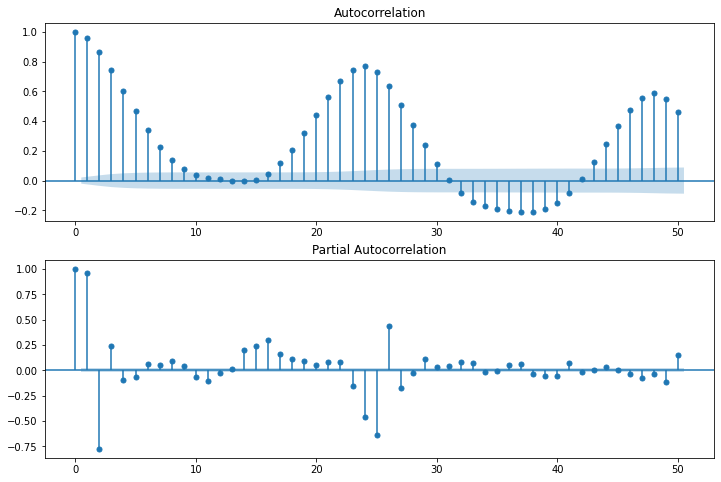

In [67]:
import plotly.offline as pyo

pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
lag = 50
fig = sm.graphics.tsa.plot_acf(hour_Load.loc[hour_Load.index > '2016'], lags=lag, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hour_Load.loc[hour_Load.index > '2016'], lags=lag, ax=ax2)

In [96]:
hour_Load['Load'].diff().iloc[1:]

Date
2008-01-01 01:00:00    False
2008-01-01 02:00:00     True
2008-01-01 03:00:00     True
2008-01-01 04:00:00     True
2008-01-01 05:00:00     True
                       ...  
2016-12-31 20:00:00     True
2016-12-31 21:00:00     True
2016-12-31 22:00:00     True
2016-12-31 23:00:00     True
2017-01-01 00:00:00     True
Name: Load, Length: 78912, dtype: bool

In [77]:
np.diff(hour_Load, 2)

array([], shape=(78912, 0), dtype=float64)

In [103]:
n = 2
adfuller(hour_Load['Load'].diff(n).iloc[n:], autolag='aic')#, maxlag=1

(-46.33631945620834,
 0.0,
 64,
 78845,
 {'1%': -3.4304329413775316,
  '5%': -2.861576658681042,
  '10%': -2.5667895121520306},
 1307825.131263261)

In [52]:
cut_dates = ['2016-12-22', '2016-12-01', '2016-11-01']

In [72]:
results = sarimax_forecasting(hour_Load.loc[hour_Load.index > '2016'], cut_dates[0])

C:\Users\cosmi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\Users\cosmi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



C:\Users\cosmi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



MemoryError: Unable to allocate 8.57 GiB for an array with shape (367, 367, 8544) and data type float64

In [ ]:
forecast = results.get_prediction(start=pd.to_datetime('2016-12-22', format='%Y-%m-%d'),
                                  end=hour_Load.index[-1])

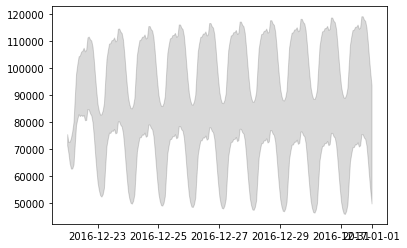

In [ ]:
hour_Load.iloc[-10*24:].plot()
forecast.predicted_mean.plot()
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower Load'], forecast.conf_int()['upper Load'], color='k', alpha=0.15)

In [50]:
def save_sarimax_results(model):   
    df = model.conf_int().copy()
    df['mean Load'] = df.mean(axis=1)
    n_days = (pd.to_datetime(df.index[-1]) - pd.to_datetime(df.index[0])).days
    df.to_csv(f"../Results/SARIMAX/Sarimax_results_{n_days}days.csv")

Text(0.5, 1.0, 'Poland Load')

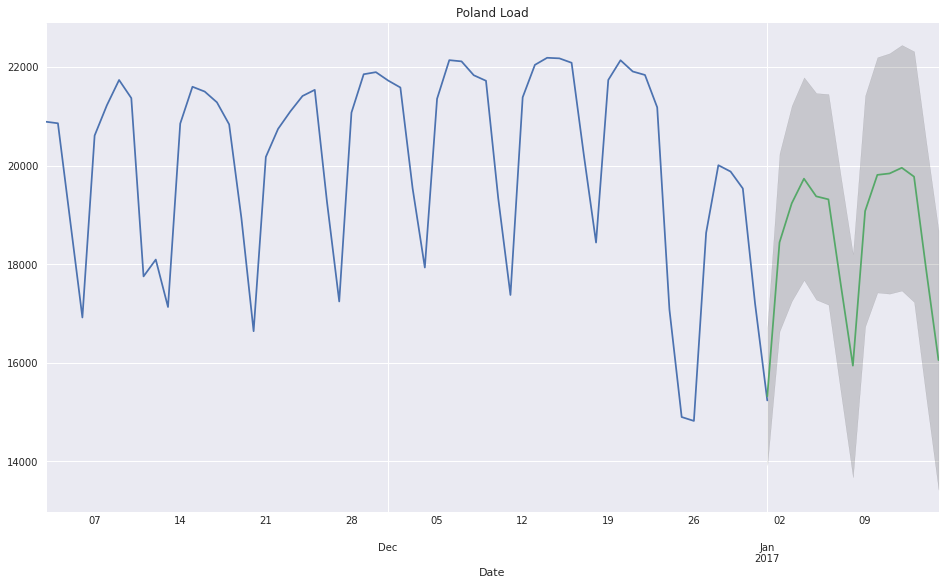

In [ ]:
forecast = results.get_prediction(start=daily_Load.index[-1], end=daily_Load.index[-1] + pd.DateOffset(days=14), dynamic= True)

daily_Load[-60:].plot()
forecast.predicted_mean.plot()
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower Load'], forecast.conf_int()['upper Load'], color='k', alpha=0.15)
plt.title('Poland Load')